In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from math import ceil,sin,cos, atan2, pi, sqrt
import pandas as pd
from cartopy import crs, feature
import requests
from bs4 import BeautifulSoup

In [255]:
import geocoder # pip install geocoder
def locat_coord(Name,province):
    g = geocoder.bing(Name+' '+province, key=APIkey)
    results = g.json
    return results['lat'], results['lng']

In [256]:
APIkey = 'Apex3rPr59EmaffYxKvl4Ypz0tjZBthExXiz1Ha_pBDtD3Q7XL7l2nMs2Ba8fwZm '

# Pulling official data from Wikipedia 2021 updated census
url = 'https://en.wikipedia.org/wiki/List_of_municipalities_in_British_Columbia'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[:-10]

Name = Data['Name'].iloc[:,0]
Pop = Data['2021 Canadian census[11]'].iloc[:,0]

d = {'Name': Name, 'Population':np.array(Pop)}
Urban = pd.DataFrame(data=d)

In [257]:
# Pulling official data from Washington Population Dataset
url = 'https://mrsc.org/Home/Research-Tools/Washington-City-and-Town-Profiles.aspx'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"full city-county-data table-interactive"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[0::3]

Name = Data['City']
Pop = Data['Population (2022)']
popu = []
for po in Pop:
    popu.append(int(po))
d = {'Name': Name, 'Population':popu}
Urban2 = pd.DataFrame(data=d)

In [258]:
lat = []
lon = []
for i in range(Urban.shape[0]):
    try:
        latn,lonn = locat_coord(Urban.Name.iloc[i],'BC')
        lat.append(latn)
        lon.append(lonn)
    except TypeError:
        print(Urban.Name.iloc[i])
        lat.append(0)
        lon.append(0)
Urban['Latitude'] = lat
Urban['Longitude'] = lon

Montrose


In [259]:
lat = []
lon = []
for i in range(Urban2.shape[0]):
    try:
        latn,lonn = locat_coord(Urban2.Name.iloc[i],'Washington')
        lat.append(latn)
        lon.append(lonn)
    except TypeError:
        print(Urban2.Name.iloc[i])
        lat.append(0)
        lon.append(0)
Urban2['Latitude'] = lat
Urban2['Longitude'] = lon

In [260]:
Urban = Urban[Urban.Latitude < 50.1]
Urban = Urban[Urban.Longitude > -125.4]
Urban = Urban[Urban.Longitude < -122]
Urban2 = Urban2[Urban2.Latitude > 47]
Urban2 = Urban2[Urban2.Longitude > -124]
Urban2 = Urban2[Urban2.Longitude < -122]
frames = [Urban, Urban2]

Urban = pd.concat(frames)

In [261]:
Urban = Urban[Urban.Population > 20000]

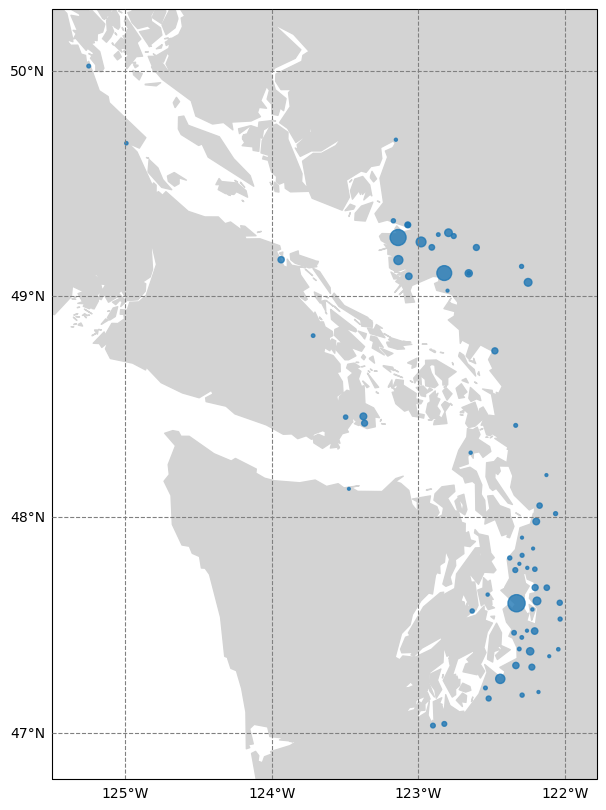

In [262]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+0.25
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='lightgray',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)

In [263]:
Urban.shape

(68, 4)

In [264]:
import xarray as xr
from salishsea_tools import river_201702 as Rivers

In [265]:
rivers = Rivers.prop_dict
bathy = xr.open_dataset('~/MOAD/grid/grid/bathymetry_202108.nc')

In [266]:
River_Name = []
River_Watershed = []
Latitude = []
Longitude = []
for watershed in (rivers.keys()):
    for name in rivers[watershed].keys():
        River_Name.append(name)
        River_Watershed.append(watershed)
        Latitude.append(bathy.nav_lat[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
        Longitude.append(bathy.nav_lon[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
d = {'Name': River_Name, 'Watershed':River_Watershed,'Latitude':Latitude,'Longitude':Longitude}
Rivers_list = pd.DataFrame(data=d)

In [267]:
Rivers_list=Rivers_list.append({'Name':'Fraser North','Watershed':'fraser','Latitude':49.198219,'Longitude': -123.132636},ignore_index=True)

/tmp/ipykernel_20017/3380534636.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Rivers_list=Rivers_list.append({'Name':'Fraser North','Watershed':'fraser','Latitude':49.198219,'Longitude': -123.132636},ignore_index=True)


In [335]:
#fixing main branch Fraser River Location
Rivers_list.iloc[93].Latitude = 49.116204 
Rivers_list.iloc[93].Longitude = -123.189394

In [336]:
colors_wsheds= {
'howe':'#F6D1BF', 
'jdf':'#AAA67E', 
'puget':'#FCF7B4',
'skagit':'#ACC752', 
'fraser':'#C0DCD1', 
'evi_n':'#B2C391', 
'jervis':'#CFCAD1', 
'toba':'#949B9D', 
'bute':'#AAD3E8', 
'evi_s':'#F0DCB4'}
cc = []
for i in range(Rivers_list.shape[0]):
    cc.append(colors_wsheds[Rivers_list.Watershed.iloc[i]])

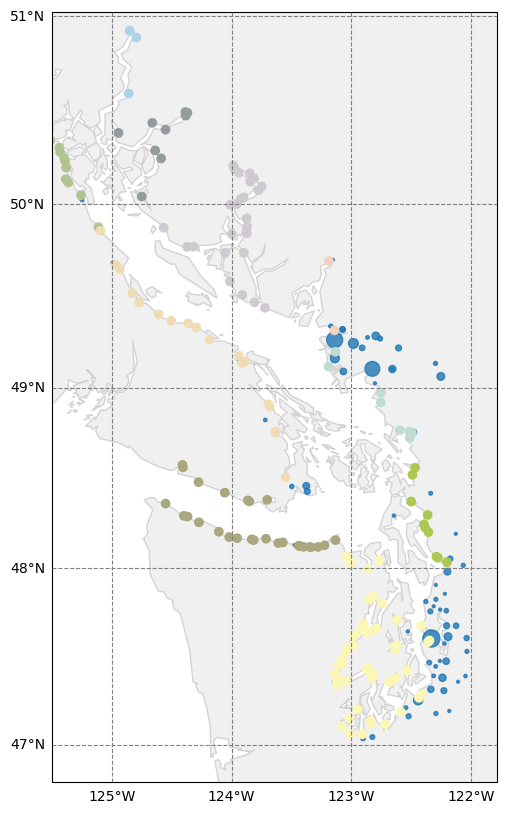

In [337]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)
riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=2,c = cc)

In [338]:
Wclass= {
'howe':1, 
'jdf':2, 
'puget':3,
'skagit':4, 
'fraser':5, 
'evi_n':6, 
'jervis':7, 
'toba':8, 
'bute':9, 
'evi_s':10}
cclas = []
for i in range(Rivers_list.shape[0]):
    cclas.append(Wclass[Rivers_list.Watershed.iloc[i]])

In [344]:
Rivers_list = Rivers_list[['Name','Watershed','Longitude','Latitude']]
keys = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

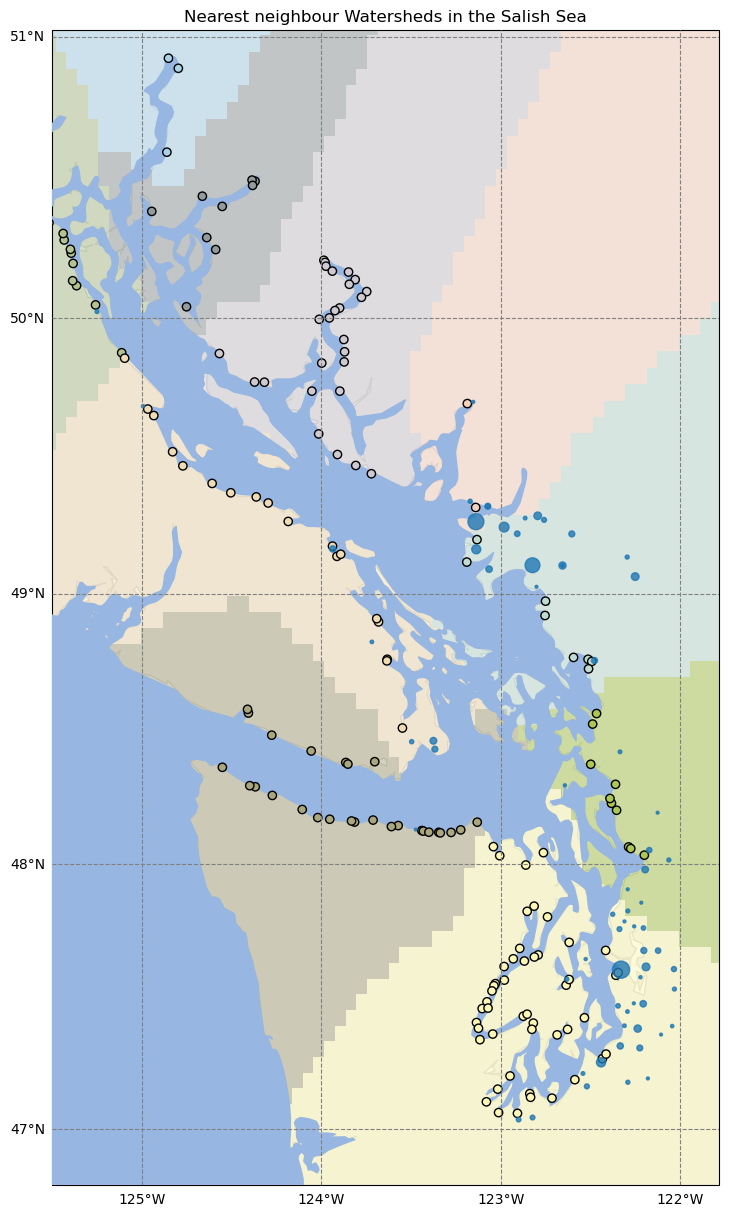

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay


n_neighbors = 1

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = Rivers_list.iloc[:,2:4]
y = cclas

# Create color maps
cmap_light = ListedColormap(['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4'])
cmap_bold = ['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4']

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
clf.fit(X, y)

lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
ax.add_feature(feature.OCEAN,zorder=3)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel='Latitude',
    ylabel='Longitude',
    alpha=0.5,
    transform=crs.PlateCarree()
)
#plt.gca().invert_yaxis()
# Plot also the training points
cit=plt.scatter(Urban.Longitude,Urban.Latitude,zorder=5,alpha=0.8,s=Urban.Population/5e3,transform=crs.PlateCarree())
riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=4,c = cc,edgecolors='k')
plt.title('Nearest neighbour Watersheds in the Salish Sea')
plt.show()